### Data Loading, getting cuda

In [1]:
import torch
import torchvision
from data_loader import get_train_valid_loader

batch_size = 128
data_path = './data/train_labeled'
resize_size = 256
crop_size = 224
train_loader, valid_loader, test_loader, classes = get_train_valid_loader(data_path, batch_size, True, resize_size, crop_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Net initialization

In [2]:
from nets.resnet import create_resnet

net = create_resnet()
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Init net weights from file (optional)

In [8]:
net_state_path = ''
net.load_state_dict(torch.load(net_state_path))

FileNotFoundError: [Errno 2] No such file or directory: './vgg-sm-drop.pth'

### Set fixed seed (optional)

In [3]:
import torch
seed = 0
torch.manual_seed(seed)

### Start training if you didn't load net state from file

In [3]:
from train import train
import torch.optim as optim
import torch 

print(f'Seed: {torch.initial_seed()}')

lr = 0.01
momentum = 0.9
num_epochs = 65
calc_train_acc = False
use_scheduler=True
step = 15
gamma = 0.1
accs_valid, losses, accs_train = train(net, train_loader, valid_loader, num_epochs, lr, 
                                       momentum, device, calc_train_acc, use_scheduler, step, gamma)
print('Finished Training')

Seed: 312619264052400


RuntimeError: CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 2.00 GiB total capacity; 1.26 GiB already allocated; 53.93 MiB free; 1.28 GiB reserved in total by PyTorch)

### Save net weights to file (optional)

In [9]:
save_path = './resnet-transfer.pth'
torch.save(net.state_dict(), save_path)

### Evaluate net on test set 

In [4]:
net.eval()
from results import get_accuracy, get_accuracy_classes
print(f'accuracy on test set: {get_accuracy(net, test_loader, device)}')

classes_accuracy = get_accuracy_classes(net, test_loader, len(classes), device, batch_size)

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], classes_accuracy[i]))

accuracy on test set: 82.62666666666667
Accuracy of airplane : 84 %
Accuracy of automobile : 93 %
Accuracy of  bird : 79 %
Accuracy of   cat : 64 %
Accuracy of  deer : 80 %
Accuracy of   dog : 68 %
Accuracy of  frog : 86 %
Accuracy of horse : 85 %
Accuracy of  ship : 91 %
Accuracy of truck : 92 %


### Plot accuracies

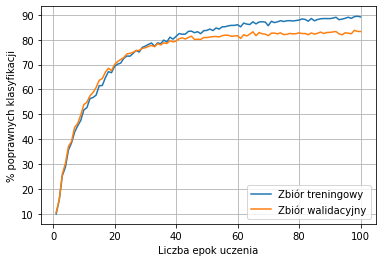

In [5]:
from graph_creator import draw_accuracy_train_valid
draw_accuracy_train_valid(accs_valid, accs_train)


### Plot loss

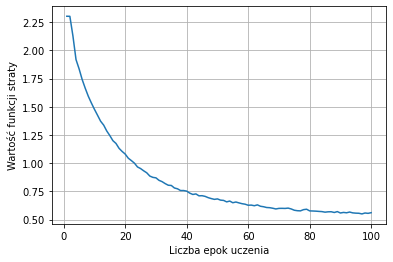

In [6]:
from graph_creator import draw_loss
draw_loss(losses)

### Plot classes accuracies

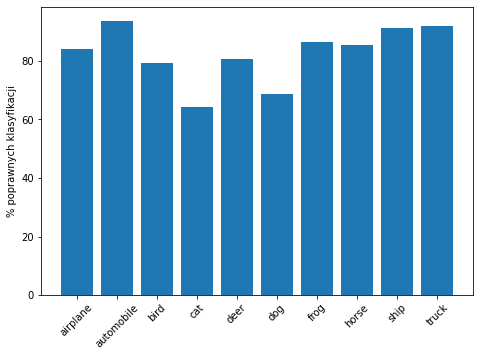

In [7]:
from graph_creator import draw_accuracies_classes
draw_accuracies_classes(classes, classes_accuracy)

### Create kaggle data 

In [ ]:
import torchvision.transforms as transforms
import csv

transfrorm_normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

valid_transforms =  transforms.Compose([
            transforms.Resize(resize_size),
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transfrorm_normalize])

testset = torchvision.datasets.ImageFolder(
        root = "./data/test_prepared",
        transform = valid_transforms, 
    )

testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

outputsLabels = []
with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data[0].to(device,non_blocking=True), data[1].to(device, non_blocking=True).long()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            for ind in predicted:
                outputsLabels.append(ind.item())
with open("./data/output.csv", 'w',newline="") as myfile:
    fields = ['id', 'label']
    wr = csv.DictWriter(myfile,fieldnames=fields)
    wr.writeheader()
    for i, label in enumerate(outputsLabels):
        wr.writerow({"id": i+1, "label": classes[label]})